**Importation**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

**Data preparation**

In [2]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'
test_path  = 'dataset/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 51 images belonging to 10 classes.


**Chargement VGG16 pre-trained on ImageNet dataset**

In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Ajout Classifier**

## last_layer = base_model.get_layer('global_average_pooling2d')

last_output = last_layer.output
x = Flatten()(last_output)
x = Dense(64, activation='relu', name='FC_2')(last_output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(10, activation='softmax', name='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=x)

new_model.summary()


In [6]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**Accuracy avant entrainement du classifier**

In [7]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1600 - loss: 6.6122
Test Loss: 6.612165927886963
Test Accuracy: 0.1599999964237213


**Entrainement du modele**

In [8]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.keras', save_best_only=True)

history = new_model.fit(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.2095 - loss: 2.3562 - val_accuracy: 0.0778 - val_loss: 45.1209
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.1444 - loss: 2.4762 - val_accuracy: 0.0778 - val_loss: 48.6174
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.2889 - loss: 2.2297 - val_accuracy: 0.1222 - val_loss: 22.8475
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.3619 - loss: 2.0227 - val_accuracy: 0.1333 - val_loss: 28.4253
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2293 - loss: 2.0139 - val_accuracy: 0.1333 - val_loss: 14.1256
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.3416 - loss: 1.7620 - val_accuracy: 0.2778 - val_loss: 4.3974
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.4334 - loss: 1.6138 - val_accuracy: 0.2222 - val_loss: 4.3855
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.3963 - loss: 1.5486 - val_accuracy: 0.0556 - val_

C:\Users\PaulE\DeepLearning\local\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6515 - loss: 1.0870 - val_accuracy: 0.1889 - val_loss: 5.3302
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.5383 - loss: 1.3045 - val_accuracy: 0.2000 - val_loss: 4.9240
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7460 - loss: 0.9109 - val_accuracy: 0.0667 - val_loss: 13.1919
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5573 - loss: 1.1120 - val_accuracy: 0.1111 - val_loss: 5.9041
Epoch 14/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7191 - loss: 0.9023 - val_accuracy: 0.3444 - val_loss: 2.3658
Epoch 15/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7982 - loss: 0.7548 - val_accuracy: 0.2333 - val_loss: 3.3685
Epoch 16/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.6748 - loss: 0.8541 - val_accuracy: 0.4889 - val_loss: 1.3212
Epoch 17/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8640 - loss: 0.5677 - val_accuracy: 0.6000 - val_loss: 0.

In [9]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2400 - loss: 9.3736
Test Loss: 9.373565673828125
Test Accuracy: 0.23999999463558197


**Rendre les dernières couches du VGG16 entrainable**

In [10]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Ajout du classifier**

In [14]:
last_layer = base_model.get_layer('global_average_pooling2d')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)
x = Dense(64, activation='relu', name='FC_2')(last_output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(10, activation='softmax', name='softmax')(x)

new_model_2 = Model(inputs=base_model.input, outputs=x)

new_model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2 (Dense)                         │ (None, 64)                  │          32,8

 Total params: 14,748,426 (56.26 MB)

 Trainable params: 7,113,034 (27.13 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [15]:
new_model_2.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**Accuracy avant entrainment**

In [16]:
test_loss, test_accuracy = new_model_2.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1000 - loss: 408.6348
Test Loss: 408.634765625
Test Accuracy: 0.10000000149011612


In [17]:
from keras.callbacks import ModelCheckpoint

checkpointer2 = ModelCheckpoint(filepath='signlanguage.lastfeatures_.model.keras', save_best_only=True)

history2 = new_model_2.fit(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer2])

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3225 - loss: 1.9772 - val_accuracy: 0.4111 - val_loss: 6.2526
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6070 - loss: 1.1872 - val_accuracy: 0.2222 - val_loss: 4.6153
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8855 - loss: 0.7962 - val_accuracy: 0.4556 - val_loss: 1.7037
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8531 - loss: 0.6422 - val_accuracy: 0.5444 - val_loss: 1.0260
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9162 - loss: 0.5988 - val_accuracy: 0.2444 - val_loss: 23.1554
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6676 - loss: 1.2241 - val_accuracy: 0.1444 - val_loss: 18.7721
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7717 - loss: 0.8396 - val_accuracy: 0.1000 - val_loss: 10.8422
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8101 - loss: 0.7738 - val_accuracy: 0.1778 - val_lo

In [18]:
test_loss, test_accuracy = new_model_2.evaluate(test_batches, steps=test_batches.samples // test_batches.batch_size, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7200 - loss: 0.8989
Test Loss: 0.8988688588142395
Test Accuracy: 0.7200000286102295


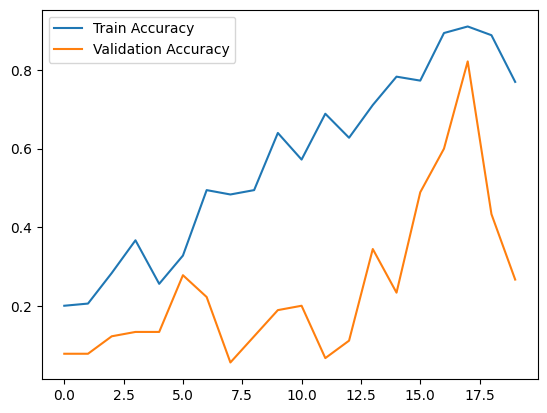

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

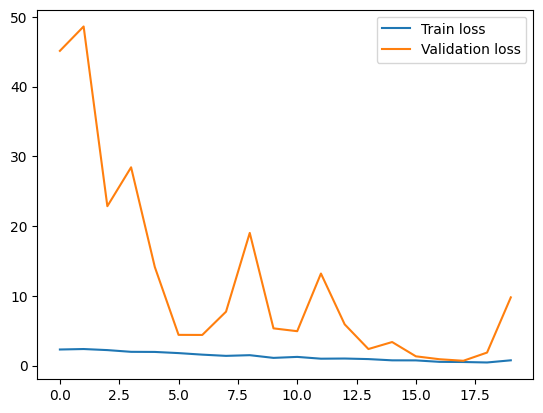

In [20]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()